# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, summarize_inference_data

## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today()-pd.Timedelta(days=4))

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [3]:
region = "Israel"
model_data = df.loc[region]

## Create the model instance and sample

In [4]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1498 seconds.


## Summarize Model Output

In [5]:
result = summarize_inference_data(gm.inference_data)

In [6]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-06,1.216514,1.208229,1.032787,1.387649,661.841270,534.417399,465.584208,1221.0,22904
2020-07-07,1.215854,1.202725,1.021266,1.404233,689.528394,557.192541,501.711209,1229.0,21394
2020-07-08,1.216192,1.204721,0.982328,1.375599,718.816379,580.715822,578.366473,1453.0,21941
2020-07-09,1.216277,1.198490,0.998567,1.404506,749.756790,605.052727,561.716566,1352.0,21021
2020-07-10,1.215701,1.198332,0.981787,1.405532,782.456938,630.263329,573.347126,967.0,14730
2020-07-11,1.216577,1.195860,0.988284,1.419217,817.164633,656.411928,570.065355,540.0,8273
2020-07-12,1.216628,1.195341,0.979294,1.428274,854.058314,683.579806,674.768674,1301.0,16839
2020-07-13,1.217987,1.199177,0.951115,1.402483,893.379051,711.865028,720.149018,1396.0,16930
2020-07-14,1.216693,1.195798,0.951764,1.426625,935.360602,741.383016,686.734894,1427.0,18148


## Plot Model Output

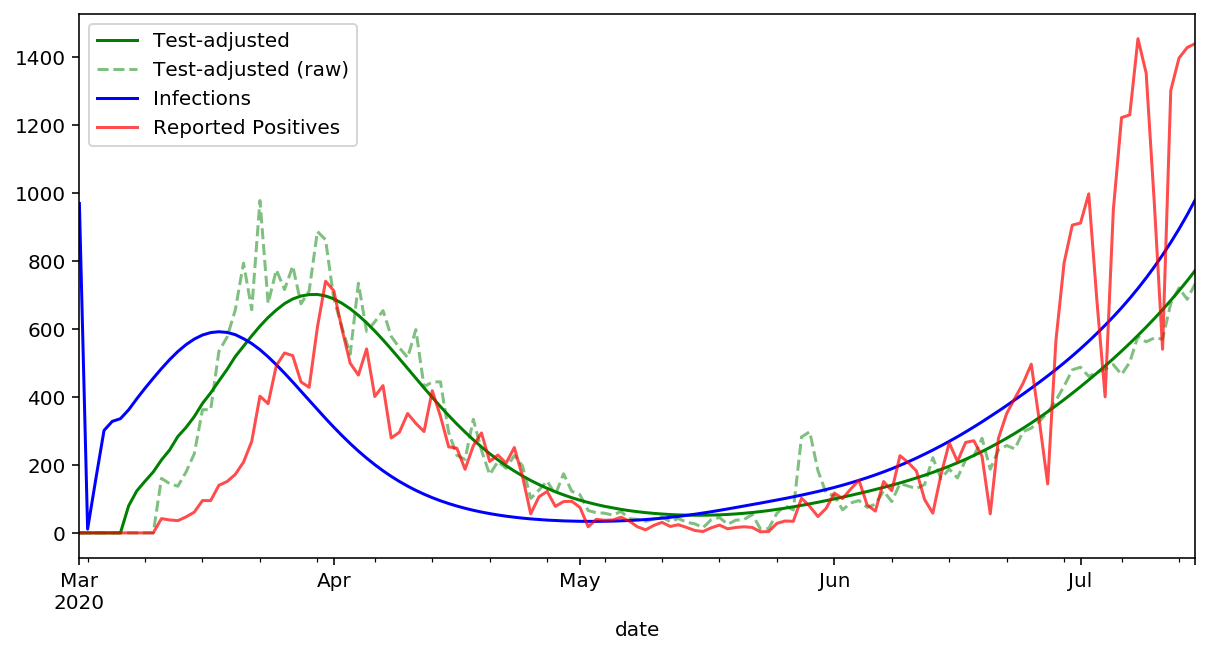

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result.infections.plot(c="b", label="Infections")
gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

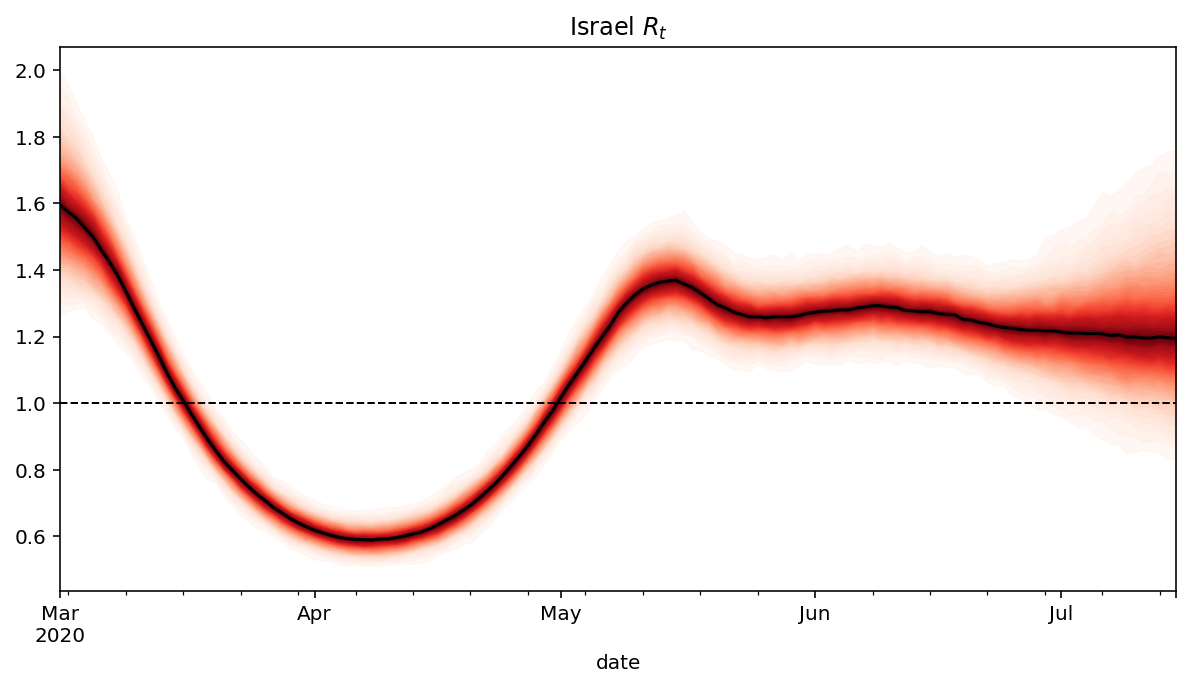

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')